In [40]:
import unittest

import matplotlib.pyplot as plt
import torch
#from functorch import vmap
from torch.autograd.functional import _vmap as vmap
import numpy as np
from scipy.linalg import block_diag
from src.spaces.so import SO
from src.spaces.su import SU
from src.spectral_kernel import EigenbasisSumKernel, EigenbasisKernel
from src.spectral_measure import SqExpSpectralMeasure, MaternSpectralMeasure
from src.prior_approximation import RandomPhaseApproximation
from src.utils import cartesian_prod
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
dtype = torch.float64
cdtype = torch.complex128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
j = torch.tensor([1j], device=device, dtype=torch.complex128).item()  # imaginary unit
pi = 2*torch.acos(torch.zeros(1)).item()


In [41]:
def id_imag_exp(lmd):
    lmd = 2*np.pi*lmd
    return np.array([
                [np.cos(lmd), np.sin(lmd)],
                [np.sin(-lmd), np.cos(lmd)]
                    ],dtype=np.float64)

def eigvals_to_so3(lmd):
    return block_diag(id_imag_exp(lmd), np.eye(1, dtype=np.float64))

def eigvals_to_so5(lmd):
    lmd1, lmd2 = lmd[0], lmd[1]
    return block_diag(id_imag_exp(lmd1), id_imag_exp(lmd2), np.eye(1, dtype=np.float64))

def eigvals_to_su2(lmd):
    lmd = 2*np.pi*lmd
    return block_diag(np.exp(j*lmd), np.exp(-j*lmd))

def eigvals_to_su3(lmd):
    lmd = 2j*np.pi*lmd
    lmd1, lmd2 = lmd[0], lmd[1]
    return block_diag(np.exp(lmd1), np.exp(lmd2), np.exp(-(lmd1+lmd2)))

In [42]:
so3 = SO(n=3, order=10)
lengthscale, nu, variance = 0.5, 3.0, 4.0
measure = SqExpSpectralMeasure(so3.dim, lengthscale)
#measure = MaternSpectralMeasure(so3.dim, lengthscale, nu, variance)
so3_kernel = EigenbasisSumKernel(measure=measure, manifold=so3)

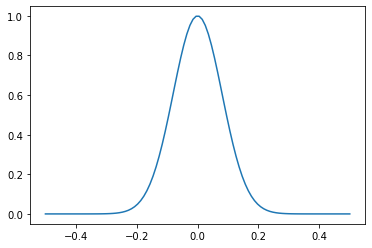

In [43]:
gr_n = 100
lmds = np.linspace(-0.5, 0.5, gr_n)
so3_points = np.vectorize(eigvals_to_so3,signature='()->(n,n)')(lmds)
so3_points = torch.tensor(so3_points, dtype=dtype, device=device)
id = torch.eye(3, device=device, dtype=dtype).view(-1,3,3)
cov = so3_kernel(so3_points, id).real.detach().cpu().squeeze()
plt.plot(lmds, cov)

In [44]:
su2 = SU(n=2, order=10)
su2_kernel = EigenbasisSumKernel(measure=measure, manifold=su2)

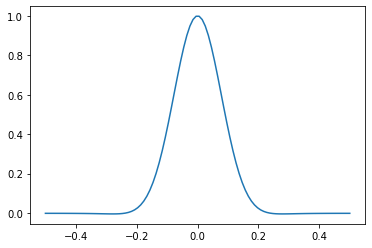

In [45]:
su2_points = np.vectorize(eigvals_to_su2,signature='()->(n,n)')(lmds)
su2_points = torch.tensor(su2_points, dtype=cdtype, device=device)
id = torch.eye(2, device=device, dtype=cdtype).view(-1,2,2)
cov = su2_kernel(su2_points, id).real.detach().cpu().squeeze()
plt.plot(lmds, cov)

In [46]:
so5 = SO(n=5, order=10)
lengthscale, nu, variance = 1, 3.0, 4.0
measure = SqExpSpectralMeasure(so5.dim, lengthscale)
#measure = MaternSpectralMeasure(so5.dim, lengthscale, nu, variance)
so5_kernel = EigenbasisSumKernel(measure=measure, manifold=so5)

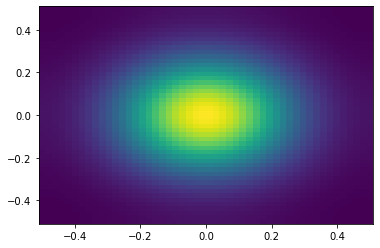

In [47]:
gr_n = 50
lspace = np.linspace(-0.5, 0.5, gr_n)
lmds = np.dstack(np.meshgrid(lspace, lspace)).reshape(-1, 2)
so5_points = np.vectorize(eigvals_to_so5,signature='(m)->(n,n)')(lmds)
so5_points = torch.tensor(so5_points, dtype=dtype, device=device)
id = torch.eye(5, device=device, dtype=dtype).view(-1,5,5)
cov = so5_kernel(so5_points, id).real.detach().cpu().squeeze().reshape(gr_n, gr_n)
x, y = np.meshgrid(lspace, lspace)
plt.pcolormesh(x, y, cov)

In [48]:
su3 = SU(n=3, order=10)
lengthscale, nu, variance = 1, 3.0, 4.0
measure = SqExpSpectralMeasure(su3.dim, lengthscale)
#measure = MaternSpectralMeasure(su3.dim, lengthscale, nu, variance)
su3_kernel = EigenbasisSumKernel(measure=measure, manifold=su3)

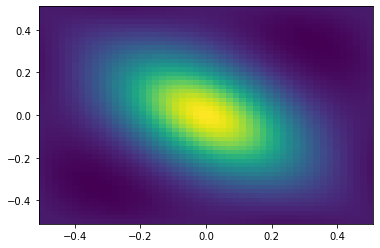

In [49]:
gr_n = 50
lspace = np.linspace(-0.5, 0.5, gr_n)
lmds = np.dstack(np.meshgrid(lspace, lspace)).reshape(-1, 2)
su3_points = np.vectorize(eigvals_to_su3,signature='(m)->(n,n)')(lmds)
su3_points = torch.tensor(su3_points, dtype=cdtype, device=device)
id = torch.eye(3, device=device, dtype=cdtype).view(-1,3,3)
cov = su3_kernel(su3_points, id).real.detach().cpu().squeeze().reshape(gr_n, gr_n)
x, y = np.meshgrid(lspace, lspace)
plt.pcolormesh(x, y, cov)
